 ## Homework 13 Jupyter Notebook
 ### First Jupyter Notebook

### 2. Grade
- **Readability: 3/3** - Great job commenting your code and provided an explanaiton for what you did and why. I like how your markdown cells are interspersed with your code blocks!
- **Style: 2.5/3** Generally good job with the python style. However, you are missing your markdown formatting. A lot of times you had '#' before the text but there was no space after them so they weren't actually doing anything. I added spaces after your '#'s below so you can see how the formatitng works however I'm not sure if this is what you were going for as you have a lot of whole sentences as headings. 
- **Code: 1.5/3** Awesome! (-0.5) It looks like you are missing a code block at the top where you import the packages. As a result your code wouldn't run for me because it says its missing packages. (-0.5) Data wouldn't load because the paths are to your local desktop rather than relative paths that will work for anyone. (-0.5) Missing added functionality from the jupyter gallery. 

This notebook provides data from the USGS stream gauge data that is used to creat 2 graphs. One showing the flow values for the week chosen and another graph showing the log flow for November and December. The USGS data also is used to predict the forecast from 11/21 - 11/27 and 11/28 - 12/4 by taking the median value from each week from 2010-2019. To create the map, the ASU geodatabase was used to gather precipitation values from 1961-1990, along with USGS data for watersheds in AZ.

## Importing Statements

In [18]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import xarray as xr
import contextily as ctx
import geopandas as gpd
import fiona
import numpy as np
from shapely.geometry import Point
import urllib.request as req
import pygrib as pg

# Importing Stream Gauge - Verde River near Camp Verde

In [1]:
url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=09506000" \
       "&referred_module=sw&period=&begin_date=1989-01-01&end_date=2020-11-20"

# Now we can read it with read_table command the same as we did before
# (note run this without the skiprows and names to show what those are doing)
data = pd.read_table(url, sep='\t', skiprows=30,
                      names=['agency_cd', 'site_no',
                              'datetime', 'flow', 'code'],
                              parse_dates=['datetime'])
data['year'] = pd.DatetimeIndex(data['datetime']).year
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).day
data['dayofweek'] = pd.DatetimeIndex(data['datetime']).dayofweek
datai = data.copy()
datai = datai.set_index('datetime')

NameError: name 'pd' is not defined

Graph of streamflow for 11/21 - 11/30 from 2010-2020

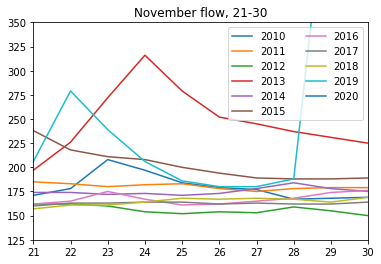

In [48]:
fig, ax = plt.subplots()
for i in range(2010, 2021):
    plot_data = data[(data['year'] == i) & (data['month'] == 11)]
    ax.plot(plot_data['day'], plot_data['flow'],
    label=i)
    ax.set(title="November flow, 21-30", xlim=[21, 30], ylim=[125, 350])
    ax.legend(ncol=2)
plt.show()
fig.savefig("Graph1.png")

## This graph shows November flow from 2010-2020 between the dates of the 21st-30th. I did cut off the graph to focus more on the average flow over the 10 years, with a huge annomally in 2019 that is close to 800cfs on the 30th. Majority of the years have flows around 175cfs. 

Multipanel plot histograms of flow for November and December

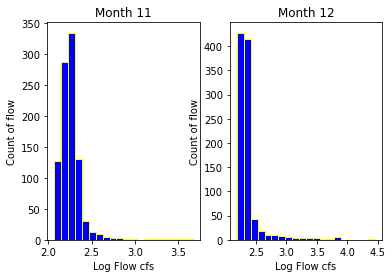

In [44]:
fig, ax = plt.subplots(1,2)

m = 11
month_data = data[data['month'] == m]
plot_title = 'Month ' + str(m)
ax[0].hist(np.log10(month_data['flow']), bins=20, edgecolor='yellow', color='blue')
ax[0].set(xlabel='Log Flow cfs', ylabel='Count of flow', title=plot_title)

m=12
month_data = data[data['month'] == m]
plot_title = 'Month ' + str(m)
ax[1].hist(np.log10(month_data['flow']), bins=20,
           edgecolor='yellow', color='blue')
ax[1].set(xlabel='Log Flow cfs', ylabel='Count of flow', title= plot_title)
plt.show()
fig.savefig("Graph2.png")

### This graph shows that the average flow in December is higher than in November, with generally more rain throughout the month. Both months show more rain in the beginning months.

Map of annual precipiation from 1996-1990

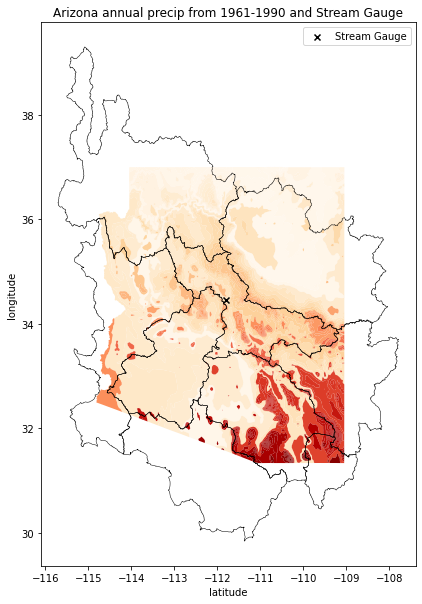

In [65]:
file = os.path.join('/Users/sierra/Desktop/Desktop - Sierra’s MacBook Pro/Fall 2021/HASTools/homework-sbettis319/data/Average_Annual_Precipitation_-_AZ_(1961_-_1990)-shp')
fiona.listlayers(file)
precip = gpd.read_file(file)

type(precip)
precip.head
precip.columns

# Can see the geometry type of each row like this:
precip.geom_type
# can see the projection here
precip.crs
# And the total spatial extent like this:
precip.total_bounds
precip_project = precip.to_crs(epsg=4269)
# Adding a point for the location of the stream gauge
# Stream gauge:  34.44833333, -111.7891667
point_list = np.array([[-111.7891667, 34.44833333]])
point_geom = [Point(xy) for xy in point_list]
point_geom

# Map a dataframe of these points
point_df = gpd.GeoDataFrame(point_geom, columns=['geometry'],
                            crs=precip_project.crs)

# HUC4 dataset
file = os.path.join('/Users/sierra/Desktop/Desktop - Sierra’s MacBook Pro/Fall 2021/HASTools/homework-sbettis319/data/Shape/WBDHU4.shp')
fiona.listlayers(file)
HU4 = gpd.read_file(file, layer="WBDHU4")
HU4_project = HU4.to_crs(precip_project.crs)

point_project = point_df.to_crs(epsg=4269)

#Putting the annual precip, stream gauge point, and watershed boundaries together
fig, ax = plt.subplots(figsize=(10, 10))
precip_project.plot(categorical=False,
                    legend=True, markersize=45, cmap='OrRd', ax=ax)
point_project.plot(ax=ax, color='black', marker='x',
                   label='Stream Gauge')
HU4_project.boundary.plot(ax=ax, color=None,
                          edgecolor='black', linewidth=0.5)
ax.set(title="Arizona annual precip from 1961-1990 and Stream Gauge",
       xlabel='latitude', ylabel='longitude')
ax.legend()
plt.show()
fig.savefig("Map1.png")

## This map shows the annual precip in AZ from 1961-1990, as well as the location of the stream gauge, and the watershed boundaries provided by the USGS.

I first downloaded the shapefile data from the ASU geodatabase to get the precip data. Next I added a point using the latitude and longitude of the stream gauge of interest and converted it to a dataframe and then projected it to the same projection as the precip data. I also added the HUC4 watershed boundaries to provide more detail into where the stream gauge lies within AZ and then projected it to the same projection as the precip data. Finally, I added all of the projections together as well as labeling a title, axes, and a legend for the point.

Forecast - function based off of the mean values from the USGS stream gauge data for the Verde River near Camp Verde

In [64]:
def forecasts(start, end):
        '''
        This function determines the week 1 and week 2 forecast predictions based on Camp Verde data
        Parameters:
        "start" represents this Saturday, the 20th.
        "end" represents the end of the first week, the 17th.
        Outputs:
        This function returns a print statement that provides the forecasted flows for week 1 and week 2. 
        '''

        week_median1 = np.median(datai['flow']['2010-11-21':'2019-11-27'])
        week_median2 = np.median(datai['flow']['2010-11-28':'2019-12-4'])
        prediction = print("The forecast for week 1 is:", week_median1 , \
                "and the forecast for week 2 is:", week_median2)
        return(prediction)

forecasts(21, 27)


The forecast for week 1 is: 141.5 and the forecast for week 2 is: 141.5


## Although these values are the average, there are chances of rain next week and so I am increasing the week 1 forecast to 160cfs.

I usually make my predictions using the median values from 2010-2019 for each week using the USGS stream gauge data, excluding 2020 because of the very low flow values, but now I have made it into a function so that it is easier to follow along with. I have not incorporated the predicted flow values into the script but my values have not been too far off with the median values. 

# Notebook explanation and link: 
